In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyvis.network import Network
import numpy as np


## Datos

Vamos a continuar trabajando con los datos de cora. El código para cargar es el mismo que el de la Actividad 11. 

In [5]:
### Información de las aristas del grafo de cora

citas = pd.read_csv('cora/cora.cites',sep="\t",
    header=None,
    names=["target", "source"])

### Metemos esto a networkx

G = nx.from_pandas_edgelist(citas, source="source", target="target",create_using=nx.DiGraph())

### Ahora levantamos la información de cada paper. Solo vamos a usar el "subject"

### Información de los nodos de cora

column_names = ["paper_id"] + [f"word_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    'cora/cora.content', sep="\t", names=column_names,
)
subjects = papers[["paper_id","subject"]]

### Agregamos la información a nuestro grafo G de esta forma: 

subjects_dict = dict(zip(subjects['paper_id'], subjects['subject']))
nx.set_node_attributes(G, subjects_dict, 'subject')

Y recordemos como se veía esto

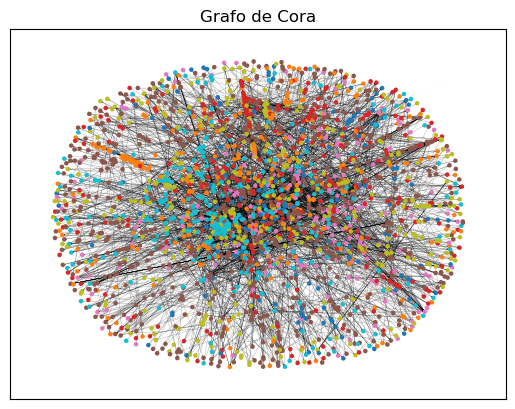

In [4]:
pos = nx.spring_layout(G)  # Layout algorithm for node positioning

# Assign a different color for each subject
unique_subjects = set(nx.get_node_attributes(G, 'subject').values())
cmap = cm.get_cmap('tab10', len(unique_subjects))
node_colors = [cmap(list(unique_subjects).index(G.nodes[node]['subject'])) for node in G.nodes]

# Draw the nodes with colors based on the 'category' attribute
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5)

# Draw the edges
nx.draw_networkx_edges(G, pos, width=0.1, arrowsize=1,node_size=5)

# Draw node labels if desired
# nx.draw_networkx_labels(G, pos)

# Adjust the plot aesthetics
plt.title('Grafo de Cora')
#plt.axis('off')

# Display the graph
plt.show()

## Comunidades

Para describir el algoritmo de detección de comunidades que vamos a usar, primero extendemos nuestra noción de betweenes centrality a aristas, de la siguiente forma. Para una arista $e$, sea $C_{u,v}$ la cantidad de caminos mas cortos entre $u$ y $v$, y $C_{u,v}(e)$ la cantidad de caminos más cortos entre $u$ y $v$ que usan $e$. 

La centralidad de e se define entonces como:
$$\sum_{u \neq v \in G, \text{$u$ y $v$ conectados}} \frac{C_{u,v}(e)}{C_{u,v}}$$

### Algoritmo de detección de comunidades de Girvan–Newman

El algoritmo (según su implementación en Networkx) funciona de la siguiente forma. 

- 1: Calcular cuantas componentes conexas tiene el grafo. 
- 2: Mientras no se generen nuevas componentes conexas: 
    - Calcular la arista con mayor betweenes centrality 
    - Remover esa arista del grafo
- 3: Cada componente conexa es una comunidad


Acá va un código en el que llamamos a esta implementación, y analizamos cada comunidad en términos del porcentaje de papers de cada uno de los subjects en esa comunidad. 

In [11]:
communities = nx.community.girvan_newman(G)

num_communities = 0
print("Detected communities:")
for community in next(communities):
    num_communities += 1
    subjects = [G.nodes[node]['subject'] for node in community]
    
    df = pd.DataFrame(subjects, columns=['subject'])
    subject_percentages = df['subject'].value_counts(normalize=True) * 100
    
    print("Community:", community)
    for subject, percentage in subject_percentages.items():
        print("Subject:", subject, "Percentage:", percentage)
    print()
print("Total number of communities:",num_communities)

Detected communities:
Community: {1122304, 1155073, 851968, 1114118, 1105932, 1114125, 253971, 8213, 696342, 696343, 696345, 696346, 8224, 950305, 262178, 35, 630817, 40, 1114153, 1130539, 385067, 131117, 131122, 16437, 188471, 16451, 1138755, 1130567, 1130568, 1114184, 16461, 1114192, 16470, 16471, 155736, 16474, 1130586, 16476, 155738, 106590, 573535, 589923, 16485, 1130600, 32872, 630890, 1114222, 573553, 65650, 114, 65653, 117, 221302, 270456, 1122425, 1114239, 128, 130, 1106052, 1130634, 1130637, 647315, 180373, 1122460, 1130653, 1130657, 164, 82087, 82090, 180399, 82098, 1130676, 1130678, 1106103, 1130680, 1106112, 590022, 1114331, 1114336, 385251, 631015, 688361, 647408, 1114352, 131315, 647413, 33013, 131318, 131317, 1106172, 1114364, 213246, 41216, 229635, 270600, 631052, 1122574, 606479, 1114388, 1122580, 647447, 1138968, 1138970, 139547, 1130780, 1114398, 213279, 288, 1130808, 1106236, 672064, 672070, 672071, 1114442, 49482, 1122642, 1130847, 90470, 1130856, 1106287, 1106298

Comparemos con las comunidades originales, dadas por las componentas conexas del grafo. 
¿Puedes ver qué componente nueva genero el algoritmo de Girvan–Newman?

In [12]:
original_communities = nx.weakly_connected_components(G)
num_original_communities = 0
for community in original_communities:
    print("Community:", community)
    num_original_communities += 1
print("Total number of components:",num_original_communities)

Community: {1122304, 1155073, 851968, 1114118, 1105932, 1114125, 253971, 8213, 696342, 696343, 696345, 696346, 8224, 950305, 262178, 35, 630817, 40, 1114153, 1130539, 385067, 131117, 131122, 16437, 188471, 16451, 1138755, 1130567, 1130568, 1114184, 16461, 1114192, 16470, 16471, 155736, 16474, 1130586, 16476, 155738, 106590, 573535, 589923, 16485, 1130600, 32872, 630890, 1114222, 573553, 65650, 114, 65653, 117, 221302, 270456, 1122425, 1114239, 128, 130, 1106052, 1130634, 1130637, 647315, 180373, 1122460, 1130653, 1130657, 164, 82087, 82090, 180399, 82098, 1130676, 1130678, 1106103, 1130680, 1106112, 590022, 1114331, 1114336, 385251, 631015, 688361, 647408, 1114352, 131315, 647413, 33013, 131318, 131317, 1106172, 1114364, 213246, 41216, 229635, 270600, 631052, 1122574, 606479, 1114388, 1122580, 647447, 1138968, 1138970, 139547, 1130780, 1114398, 213279, 288, 1130808, 1106236, 672064, 672070, 672071, 1114442, 49482, 1122642, 1130847, 90470, 1130856, 1106287, 1106298, 98693, 1114502, 2496

# Actividad Evaluada

**Parte 1.** Acá vas a programar un algoritmo que trabaje usando Girvan–Newman como subrutina. Específicamente, deberás continuar iterando el resultado a las llamadas a Girvan-Newman, volviendo a aplicar el algoritmo sobre los subgrafos inducidos por todas las comunidades donde no exista un subject que tenga una representación *mayor o igual* a 50% (es decir, en donde la mitad o más de los papers tienen el mismo subject). 

¿Cuántas comunidades encontraste?


**Parte 2.** Podría ser que tu algoritmo de la parte 1 te de dos comunidades que tengan 50% o más de sus papers con el mismo subject, pero que aparezcan como componentes conexas distintas. 
Diseña y programa una forma de arreglar este problema: Al final de la ejecución, las comunidades deben satisfacer estos dos requisitos. 
- a: En todas las comunidades la mitad o más de los papers tienen el mismo subject
- b: No existen comunidades A y B tal que la mitad o más de los papers de A y B comparten el subject, y A y B forman parte de la misma componente conexa en el grafo de cora original. 

¿Había alguna comunidad con es

**Parte 3**. Discute. ¿tiene sentido usar el subject de los papers para refinar un algoritmo de detección de comunidades? ¿Tiene sentido en general usar atributos del grafo, más allá de las aristas, para refinar la detección de comunidades? ¿Cuando ves útil esta estrategia? ¿Cuándo ves errónea esta estrategia?